In [1]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\Rock_\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_photos(directory):
    images = []
    labels = []
    for name in listdir(directory):
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(128, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value = int(name.split('_')[0])
        labels.append(value)
        images.append(image)
    return images, labels

In [3]:
#dataset = 'Dataset_cleaned'
dataset = 'RichDataset'
#dataset = 'BigDataset'

In [4]:
# load images from both train and test groups
directory = '../../../Patate_data/data/'+dataset+'/Train'
images, labels = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels for training: %d' % nb_images)
directory = '../../../Patate_data/data/'+dataset+'/Val'
images_val, labels_val = load_photos(directory)
nb_images_val = len(images_val)
print('Loaded Images and labels for validation: %d' % nb_images_val)

Loaded Images and labels for training: 1538
Loaded Images and labels for validation: 196


In [5]:
#normalise datas
images = np.array(images)
images = images[:, 40:, :, :]
images /= 255
images_val = np.array(images_val)
images_val = images_val[:, 40:, :, :]
images_val /= 255

((1538, 88, 160, 3), <matplotlib.image.AxesImage at 0x264618a6c88>)

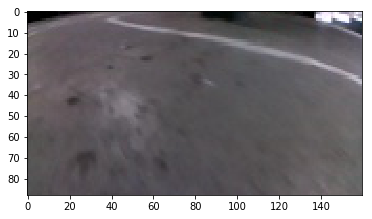

In [6]:
images.shape, plt.imshow(images[40])


In [7]:
#convert labels to np.array
labels = np.array(labels)
labels_val = np.array(labels_val)

In [8]:
#convert datas to dummyvalues
labelsd = pd.get_dummies(labels)

In [9]:
labelsd

,1,2,3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
5,1,0,0
6,1,0,0
7,1,0,0
8,1,0,0
9,1,0,0


In [10]:
#convert to np.array again
labelsd = np.array(labelsd)

In [11]:
#check if OK
labels[1], labelsd[1]

(1, array([1, 0, 0], dtype=uint8))

In [12]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers

In [13]:
#from keras.models import load_model
#model = load_model('model-BigDataset.h5')

In [42]:
K.clear_session()

img_in = Input(shape=(88, 160, 3), name='img_in')

x = img_in

x = Convolution2D(8, (4,4), strides=(4,4), activation='relu')(x)
x = Convolution2D(8, (4,4), strides=(4,4), activation='relu')(x)
x = Convolution2D(8, (4,4), strides=(4,4), activation='relu')(x)
#x = Convolution2D(128, (3,3), strides=(4,4), activation='relu')(x)

# Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
x = Dense(10, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(5, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
x = Dropout(.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)

#categorical output
out = Dense(3, activation='softmax')(x)

model = Model(inputs=[img_in], outputs=[out])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 88, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 40, 8)         392       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 10, 8)          1032      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 2, 8)           1032      
_________________________________________________________________
flattened (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
__________

In [44]:
h = model.fit(images, labelsd, batch_size=32, epochs=100, verbose=1)

Epoch 1/100
1538/1538 [==============================] - 1s 742us/step - loss: 0.9865 - acc: 0.5397
Epoch 2/100
1538/1538 [==============================] - 1s 472us/step - loss: 0.9447 - acc: 0.5826
Epoch 3/100
1538/1538 [==============================] - 1s 463us/step - loss: 0.9412 - acc: 0.5813
Epoch 4/100
1538/1538 [==============================] - 1s 525us/step - loss: 0.9463 - acc: 0.5741
Epoch 5/100
1538/1538 [==============================] - 1s 483us/step - loss: 0.9362 - acc: 0.5741
Epoch 6/100
1538/1538 [==============================] - 1s 493us/step - loss: 0.9234 - acc: 0.5780
Epoch 7/100
1538/1538 [==============================] - 1s 478us/step - loss: 0.9157 - acc: 0.5722
Epoch 8/100
1538/1538 [==============================] - 1s 549us/step - loss: 0.9007 - acc: 0.5663
Epoch 9/100
1538/1538 [==============================] - 1s 508us/step - loss: 0.8849 - acc: 0.5780
Epoch 10/100
1538/1538 [==============================] - 1s 473us/step - loss: 0.8750 - acc: 0.5813

KeyboardInterrupt: 

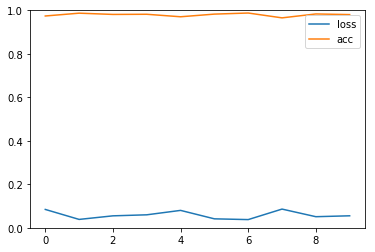

In [40]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [112]:
# Get predictions
all_preds = model.predict(images_val)

# Check predictions
idx = np.argmax(all_preds, axis=1)

i = 0
for value in idx:
    idx[i] = value + 1
    i = i + 1

idx, labels_val

(array([2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 3, 1, 1, 1, 2,
        1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1,
        1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 1, 1, 2,
        1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1,
        2, 3, 1, 1, 2, 1, 3, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 3, 2, 2,
        3, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 2, 3, 2, 1, 1,
        3, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1,
        2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 3, 1, 3, 2, 2, 2, 1, 2, 3, 2, 3,
        2, 3, 3, 3, 1, 3, 2, 2, 2, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3,
        3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 

In [113]:
import math
i = 0
res = 0
for value in idx:
    if value != labels_val[i]:
        res = res + 1
    i = i + 1
res/i

0.33114754098360655

In [26]:
model.save('model-'+dataset+'.h5')